<h1 style="text-align:center;line-height:1.5em;font-size:30px;">Data and Scripts <br>for Hydrological Streamline Detection Using a U-net Model with Attention Module</h1>
<p style="text-align:center;font-size:12px;">
$Zewei$ $Xu^{1,2}$; $Shaowen$ $Wang^{1,2}$; $Lawrence V.$ $Stanislawski^{3}$; $Zhe$ $Jiang^{4}$; $Nattapon$ $Jaroenchai^{1,2}$; $Arpan Man$ $Sainju^{4}$; $Ethan$ $Shavers^{3}$; $E. Lynn$ $Usery^{3}$; $Li$ $Chen^{2,5}$; $Zhiyu$ $Li^{1,2}$; $Bin$ $Su^{1,2}$
</p>
<p style="text-align:center;font-size:12px;">
$^{1}$$Department$ $of$ $Geography$ $and$ $Geographic$ $Information$ $Science$, $University$ $of$ $Illinois$ $at$ $Urbana-Champaign$, $Urbana$, $IL$, $USA$<br>
$^{2}$$CyberGIS$ $Center$ $for$ $Advanced$ $Digital$ $and$ $Spatial$ $Studies$, $University$ $of$ $Illinois$ $at$ $Urbana-Champaign$, $Urbana$, $IL$, $USA$<br>
$^{3}$$U.S.$ $Geological$ $Survey$, $Center$ $of$ $Excellence$ $for$ $Geospatial$ $Information$ $Science$, $Rolla$, $MO$, $USA$<br>
$^{4}$$Department$ $of$ $Computer$ $Science$, $University$ $of$ $Alabama$, $Tuscaloosa$, $AL$, $USA$<br>
$^{5}$$School$ $of$ $Geosciences$ $and$ $Info-Physics$, $Central$ $South$ $University$, $Changsha$, $Hunan$, $China$<br>
$Corresponding$ $Author:$ $nj7@illinois.edu$
</p>

---
    
**Notebook Structure:**  
[1. Introduction](1_Introduction.ipynb)  
2. Codes   
 [2.1. Data Preprocessing](2.1_Code_Data_Preprocessing.ipynb)  
 [2.2. Model Training](2.2_Code_Model_Training.ipynb)  
 [2.3. Interpret the Result](2.3_Code_Interpret_the_Result%20.ipynb)   

---

### Model Training

The following code is to define the sctructure of the CNN, U-Net, that we will use. U-Net is a famous CNN structure for feature detecting using the combination of local pattern and global pattern. So, The U-Net is the best CNN for streamline extraction. 

The following code id the definition of the CNN (U-Net).

We use the follow softwares:

- Python 2.7
- sklearn 0.18.1
- scikit-image 0.16.2
- gdal 3.0.2
- numpy 1.17.3 
- Anaconda 2.0
- keras 2.0 with backend of tensorflow 1.0


---


## **U-net Model**


<div style="text-align:center;">
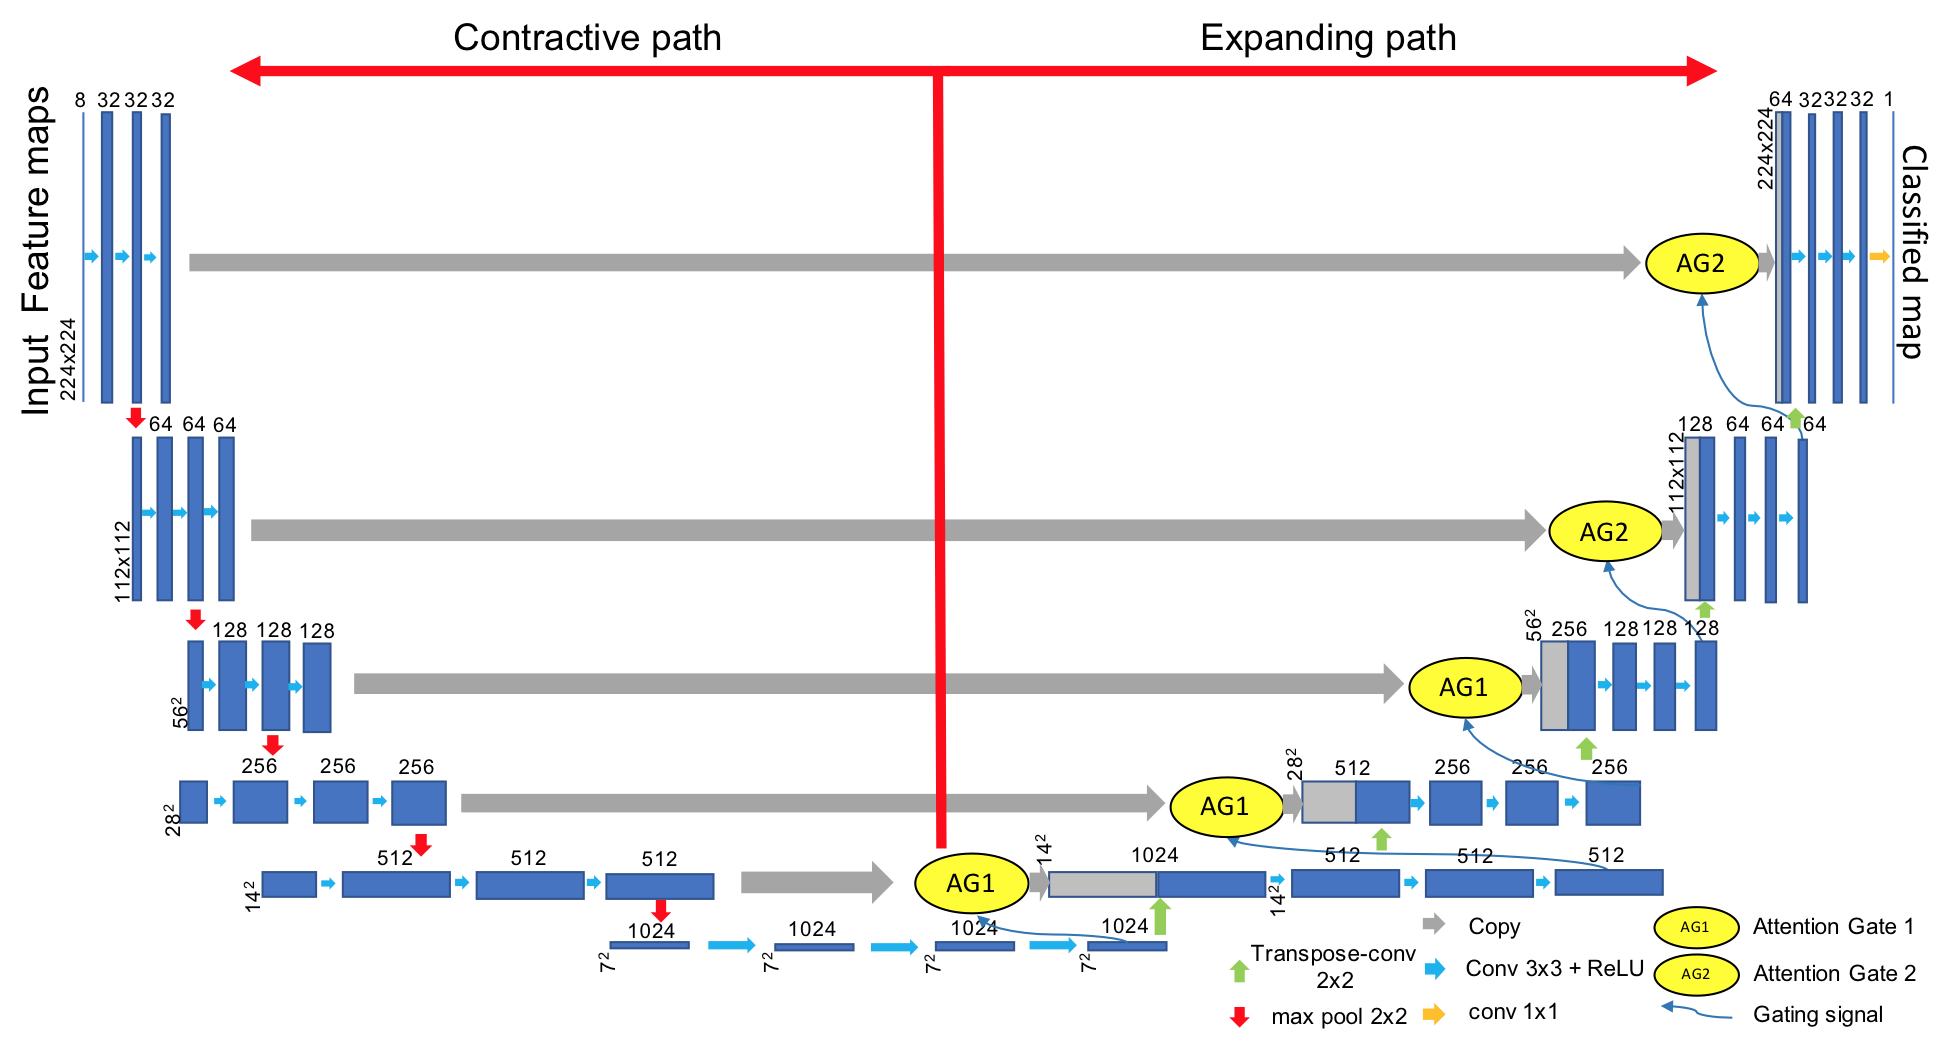
    </div>

*The attention U-net model*




---


## **Attention modules**  


We use attention gate 1 at the three shallower layers to preserve the most information and use attention gate 2, which is the revised version of attention gate 1 specifically to improve the performance of the computation of sparse metrix.

<div style="text-align:center;">
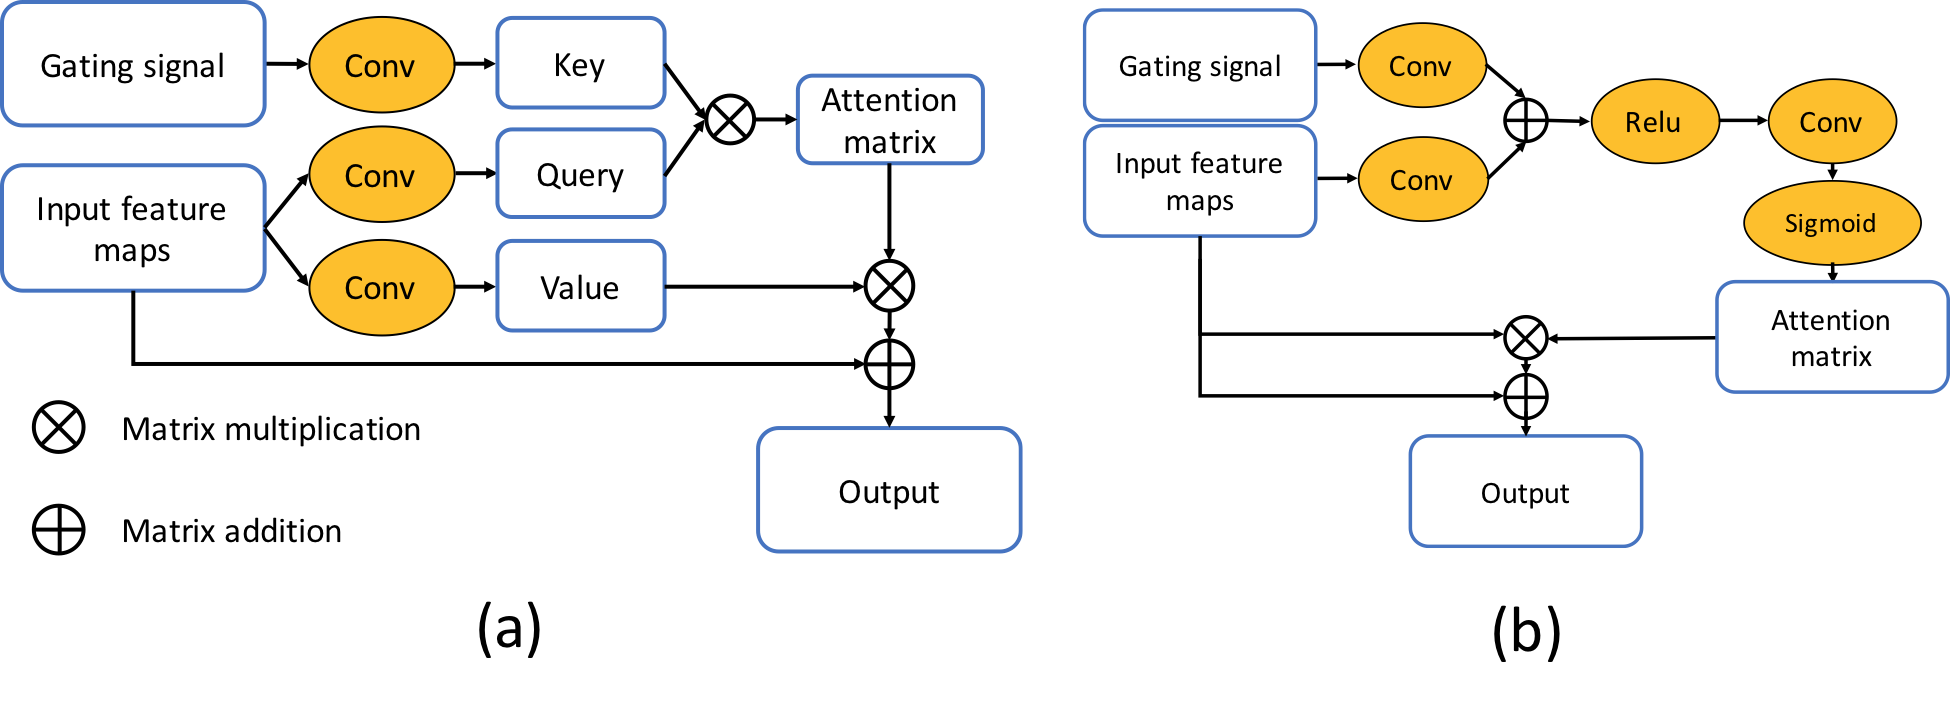
  
<p style="text-align:center;">Attention gates of the U-net model (a: attention gate 1;b: attention gate 2)</p>

</div>

In [1]:
!pip install --user tensorflow
!pip install --user keras

### Import all dependencies 

In [2]:
# Load all the dependencies
import os
import sys
import random
import warnings
import numpy as np
from numpy import genfromtxt
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow import set_random_seed
from itertools import chain
from keras.layers import Layer,UpSampling2D,merge
from keras.layers.normalization import BatchNormalization
from keras.layers.core import SpatialDropout2D, Activation
from keras.models import Model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers import Reshape, Permute, Input, add, multiply
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import tensorflow as tf
from keras.layers import dot

# To specify the GPU ID uncomment this block and  
# with K.tf.device('/gpu:0'): # specify the ID of GPU here (0: the first GPU)
#    config = tf.ConfigProto(intra_op_parallelism_threads=4,\
#           inter_op_parallelism_threads=4, allow_soft_placement=True,\
#           device_count = {'CPU' : 1, 'GPU' : 1})
#    session = tf.Session(config=config)
#    K.set_session(session)

set_random_seed(1337)
np.random.seed(1337) # for reproducibility
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

Using TensorFlow backend.
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

# Define all component for U-Net model



---

### Define  Coefficient Calculations and Residual Block



In [12]:
# Use dice coefficient function as the loss function 
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)

# Jacard coefficient
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

# calculate loss value
def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)

# calculate loss value
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def Residual_CNN_block(x, size, dropout=0.0, batch_norm=True):
    if K.image_dim_ordering() == 'th':
        axis = 1
    else:
        axis = 3
    conv = Conv2D(size, (3, 3), padding='same')(x)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    conv = Conv2D(size, (3, 3), padding='same')(conv)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    conv = Conv2D(size, (3, 3), padding='same')(conv)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    return conv



---


### **Attention modules**  


We use attention gate 1 at the three shallower layers to preserve the most information and use attention gate 2, which is the revised version of attention gate 1 specifically to improve the performance of the computation of sparse metrix.


<div style="text-align:center;">
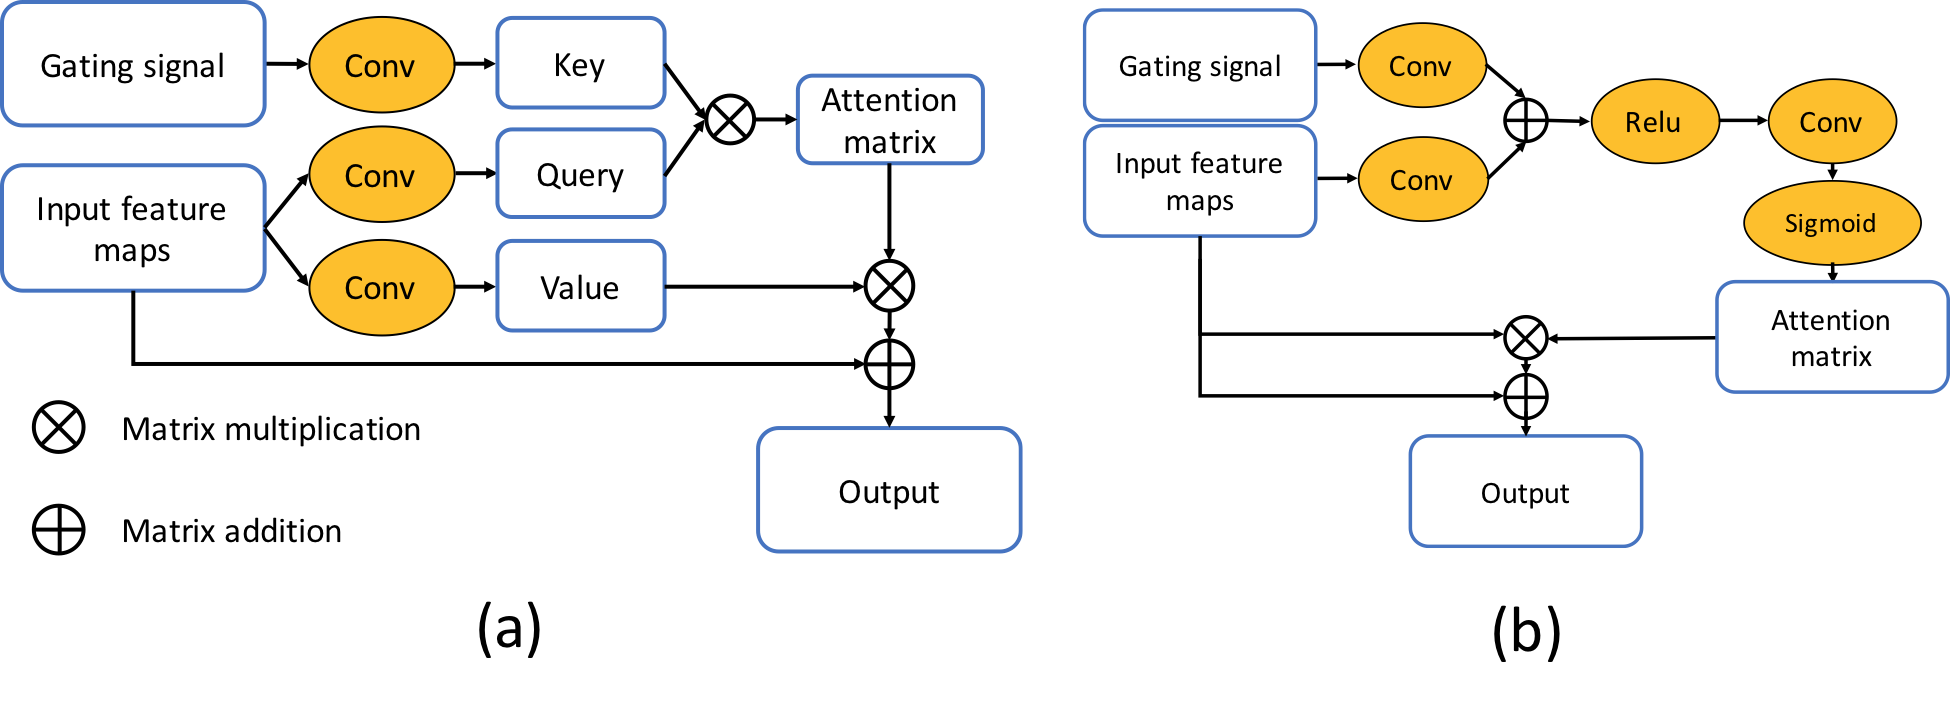
    
</div>

*Attention gates of the U-net model (a: attention gate 1;b: attention gate 2)*

In [ ]:
class multiplication(Layer):
    def __init__(self,inter_channel = None,**kwargs):
        super(multiplication, self).__init__(**kwargs)
        self.inter_channel = inter_channel
    def build(self,input_shape=None):
        self.k = self.add_weight(name='k',shape=(1,),initializer='zeros',dtype='float32',trainable=True)
    def get_config(self):
        base_config = super(multiplication, self).get_config()
        config = {'inter_channel':self.inter_channel}
        return dict(list(base_config.items()) + list(config.items()))  
    def call(self,inputs):
        g,x,x_query,phi_g,x_value = inputs[0],inputs[1],inputs[2],inputs[3],inputs[4]
        h,w,c = int(x.shape[1]),int(x.shape[2]),int(x.shape[3])
        x_query = K.reshape(x_query, shape=(-1,h*w, self.inter_channel//4))
        phi_g = K.reshape(phi_g,shape=(-1,h*w,self.inter_channel//4))
        x_value = K.reshape(x_value,shape=(-1,h*w,c))
        scale = dot([K.permute_dimensions(phi_g,(0,2,1)), x_query], axes=(1, 2))
        soft_scale = Activation('softmax')(scale)
        scaled_value = dot([K.permute_dimensions(soft_scale,(0,2,1)),K.permute_dimensions(x_value,(0,2,1))],axes=(1, 2))
        scaled_value = K.reshape(scaled_value, shape=(-1,h,w,c))        
        customize_multi = self.k * scaled_value
        layero = add([customize_multi,x])
        my_concat = Lambda(lambda x: K.concatenate([x[0], x[1]], axis=3))
        concate = my_concat([layero,g])
        return concate 
    def compute_output_shape(self,input_shape):
        ll = list(input_shape)[1]
        return (None,ll[1],ll[1],ll[3]*3)
    def get_custom_objects():
        return {'multiplication': multiplication}

def attention_up_and_concatenate(inputs):
    g,x = inputs[0],inputs[1]
    inter_channel = g.get_shape().as_list()[3]
    g = Conv2DTranspose(inter_channel, (2,2), strides=[2, 2],padding='same')(g)
    x_query = Conv2D(inter_channel//4, [1, 1], strides=[1, 1], data_format='channels_last')(x)
    phi_g = Conv2D(inter_channel//4, [1, 1], strides=[1, 1], data_format='channels_last')(g)
    x_value = Conv2D(inter_channel//2, [1, 1], strides=[1, 1], data_format='channels_last')(x)
    inputs = [g,x,x_query,phi_g,x_value]
    concate = multiplication(inter_channel)(inputs)
    return concate

In [ ]:
class multiplication2(Layer):
    def __init__(self,inter_channel = None,**kwargs):
        super(multiplication2, self).__init__(**kwargs)
        self.inter_channel = inter_channel
    def build(self,input_shape=None):
        self.k = self.add_weight(name='k',shape=(1,),initializer='zeros',dtype='float32',trainable=True)
    def get_config(self):
        base_config = super(multiplication2, self).get_config()
        config = {'inter_channel':self.inter_channel}
        return dict(list(base_config.items()) + list(config.items()))  
    def call(self,inputs):
        g,x,rate = inputs[0],inputs[1],inputs[2]
        scaled_value = multiply([x, rate])
        att_x =  self.k * scaled_value
        att_x = add([att_x,x])
        my_concat = Lambda(lambda x: K.concatenate([x[0], x[1]], axis=3))
        concate = my_concat([att_x, g])
        return concate 
    def compute_output_shape(self,input_shape):
        ll = list(input_shape)[1]
        return (None,ll[1],ll[1],ll[3]*2)
    def get_custom_objects():
        return {'multiplication2': multiplication2}

def attention_up_and_concatenate2(inputs):
    g, x = inputs[0],inputs[1]
    inter_channel = g.get_shape().as_list()[3]
    g = Conv2DTranspose(inter_channel//2, (3,3), strides=[2, 2],padding='same')(g)
    g = Conv2D(inter_channel//2, [1, 1], strides=[1, 1], data_format='channels_last')(g)
    theta_x = Conv2D(inter_channel//4, [1, 1], strides=[1, 1], data_format='channels_last')(x)
    phi_g = Conv2D(inter_channel//4, [1, 1], strides=[1, 1], data_format='channels_last')(g)
    f = Activation('relu')(add([theta_x, phi_g]))
    psi_f = Conv2D(1, [1, 1], strides=[1, 1], data_format='channels_last')(f)
    rate = Activation('sigmoid')(psi_f)
    concate =  multiplication2()([g,x,rate])
    return concate

### Construct the U-Net model

In [13]:
def UNET_224(weights=None):
    inputs = Input((IMG_WIDTH, IMG_WIDTH, INPUT_CHANNELS))
    filters = 32
    last_dropout = 0.2
# convolutiona and pooling level 1
    conv_224 = Residual_CNN_block(inputs,filters)
    pool_112 = MaxPooling2D(pool_size=(2, 2))(conv_224)
# convolutiona and pooling level 2
    conv_112 = Residual_CNN_block(pool_112,2*filters)
    pool_56 = MaxPooling2D(pool_size=(2, 2))(conv_112)
# convolutiona and pooling level 3
    conv_56 = Residual_CNN_block(pool_56,4*filters)
    pool_28 = MaxPooling2D(pool_size=(2, 2))(conv_56)
# convolutiona and pooling level 4
    conv_28 = Residual_CNN_block(pool_28,8*filters)
    pool_14 = MaxPooling2D(pool_size=(2, 2))(conv_28)
# convolutiona and pooling level 5
    conv_14 = Residual_CNN_block(pool_14,16*filters)
    pool_7 = MaxPooling2D(pool_size=(2, 2))(conv_14)
# Conlovlution and feature concatenation
    conv_7 = Residual_CNN_block(pool_7,32*filters)
# Upsampling with convolution 
    up_14 = attention_up_and_concatenate([conv_7, conv_14]) 
    up_conv_14 = Residual_CNN_block(up_14,16*filters)
# Upsampling with convolution 2
    up_28 = attention_up_and_concatenate([up_conv_14, conv_28])
    up_conv_28 = Residual_CNN_block(up_28,8*filters)
# Upsampling with convolution 3
    up_56 = attention_up_and_concatenate2([up_conv_28, conv_56])
    up_conv_56 = Residual_CNN_block(up_56,4*filters)
# Upsampling with convolution 4
    up_112 = attention_up_and_concatenate2([up_conv_56, conv_112])
    up_conv_112 = Residual_CNN_block(up_112,2*filters)
# Upsampling with convolution 5
    up_224 = attention_up_and_concatenate2([up_conv_112, conv_224])
    #up_224 = attention_up_and_concatenate2(up_conv_112, conv_224)
    up_conv_224 = Residual_CNN_block(up_224,filters,dropout = last_dropout)
# 1 dimensional convolution and generate probabilities from Sigmoid function
    conv_final = Conv2D(OUTPUT_MASK_CHANNELS, (1, 1))(up_conv_224)  
    conv_final = Activation('sigmoid')(conv_final)
# Generate model
    model = Model(inputs, conv_final, name="UNET_224")
    return model


### Reading the input 

The followig code will initiate the trainging and validating dataset. Then, is initialize the U-Net CNN with all substantial parameters.

In [14]:
#Path to input files
root="/home/jovyan/shared_data/data/unet_streamline_detection/"

# n/n2: upper_half_as_train_validation/lower_half_as_train_validation, 
# v/v2:left_half_as_train_validation/right_half_as_train_validation
m='v2'
import os
import numpy as np
import sys
aug = '_aug'+m #m is set in the first code block as 'v2' as default
# read in training and validation data
X_train = np.load(root+'data/generated/train_data'+aug+'.npy')#[:2000]
Y_train = np.load(root+'data/generated/train_label'+aug+'.npy')#[:,:,:,np.newaxis]#[:,:,:,np.newaxis]#[:2000]
X_Validation = np.load(root+'data/generated/vali_data'+aug.split('_aug')[-1]+'.npy')#[:700]
Y_Validation = np.load(root+'data/generated/vali_label'+aug.split('_aug')[-1]+'.npy')
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

print(X_train.shape)
print(Y_train.shape)
print(X_Validation.shape)
print(Y_Validation.shape)

(245, 224, 224, 8)
(245, 224, 224, 1)
(20, 224, 224, 8)
(20, 224, 224, 1)


In [15]:
patch_size = 224

IMG_WIDTH = patch_size
IMG_HEIGHT = patch_size
# Number of feature channels 
INPUT_CHANNELS = 8
# Number of output masks (1 in case you predict only one type of objects)
OUTPUT_MASK_CHANNELS = 1
maxepoch = 10
# hyperparameters
learning_rate =0.0000359
patience = 20

# create the CNN
model = UNET_224()
model.compile(optimizer=Adam(lr=learning_rate),loss = dice_coef_loss,metrics=[dice_coef,'accuracy'])
callbacks = [
        ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=patience, min_lr=1e-9, verbose=1, mode='min'),
        EarlyStopping(monitor='val_loss', patience=patience, verbose=0),
        ModelCheckpoint('unetLr03Full.h5', monitor='val_loss', save_best_only=True, verbose=0),
    ]


### Train the model
The following line of code is the code for training the CNN with the trainging and validating datasets. To run this code we recommend running it in an environment that have GPU. It will take several hours to finish if you run it in this notebook. 

The result of the trainging and validating processes are saved 

<br>

> results_03 = model.fit(X_train, Y_train, validation_data=(X_Validation,Y_Validation), batch_size=16, epochs=maxepoch, callbacks=callbacks)

<br>

*Note: Due to the limitation of the resources we do not encourage you to run this training part. In order to run this model, we suggest running the model on the machine with GPU or CPU with large memory. Running the model in this environment will take several hours.*

### Save the Trained model

The cell below is the code for saving the result of training and validating. The code will save the results into 4 files in **"result"** folder. The files are as follows:
1. **model_\*_attention2.yaml:** the model structure and not its weights or its training configuration
2. **model_\*_attention2.h5:** the trained model structure and weights that we can use to predict new set of data. 
3. **history_\*_attention2.pickle:** the log of the trainging and validating processes which contains the statistic of training and validating phases.
4. **preds_test_total_\*_attention2.npy:** the result of the trained model with the testing dataset.

>from keras.models import load_model  
>import pickle  
>from keras.models import model_from_yaml  
>  
>*\# save the trained model*  
>model_yaml = model.to_yaml()  
>with open(root+"result/model"+aug+"_attention2.yaml", "w") as yaml_file:  
>    yaml_file.write(model_yaml)  
>  
>*\# save the weights*  
>model.save(root+'result/model'+aug+'_attention2.h5')  
>*\# save the intermdediate results and training statistics*  
>with open(root+'result/history'+aug+'_attention2.pickle', 'wb') as file_pi:  
>    pickle.dump(results_03.history, file_pi, protocol=2)  
>      
>*\# load the prediction input*  
>X_test = np.load(root+"data/prediction_data.npy")  
>X_test.shape  
>  
>*\# Save the predicted labels.*  
>X_test = np.load("prediction_data.npy")  
>preds_test = model.predict(X_test)  
>preds_test_t = (preds_test > 0.5).astype(np.uint8)  
>np.save(root+'result/preds_test_total'+aug+'_attention2.npy',preds_test_t)  

*Note: This section is disabled becasue it will always show error becasue we do not finish the training step*